# titanic Top 4% with ensemble modeling

참고 : https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling

# 1st

# 1. Introduction

main parts :
- Feature analysis
- Featrue engineering
- Modeling

In [66]:
# -*- coding: utf-8 -*-
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white',context='notebook',palette='deep')

# 2. Load and check data

## 2.1. Load data

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
IDtest = test['PassengerId']

## 2.2. Outlier detection

In [3]:
def detect_outliers(df,n,features):
    """ featrue의 dataframe을 사용하고 
    Tukey방법에 따라 outlier가 n개 이상인 관측치의 인덱스 목록을 반환 """
    outlier_indices = []
    
    # feature의 columns 반복
    for col in features:
        # 1사분위수(25%)
        Q1 = np.percentile(df[col],25)
        # 3사분위수(75%)
        Q3 = np.percentile(df[col],75)
        # IQR (Interquartile range)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5*IQR
        
        # feature columns의 outlier 인덱스 목록 저장
        outlier_list_col = df[(df[col]<Q1-outlier_step) | (df[col]>Q3+outlier_step)].index
        
        # 추출한 oiutlier의 인덱스 목록을 outlier_indices 변수에 추가
        outlier_indices.extend(outlier_list_col)
        
    # outlier가 n개 이상인 관측치 선택
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)
        
    return multiple_outliers
    
# Age, SibSp, Parce, Fare 변수에서 outlier 색출
Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

outlier는 예측(특히 회귀 문제에서)에 극적인 영향을 줄 수 있으므로 outlier를 처리해야한다.<br><br>
Tukey 방법으로 분포 값의 1사분위수와 3사분위수의 차이인 IQR(사분위간 범위)를 정의해 outlier를 색출했다. outlier는 IQR +- outlier step 값 외의 행이다. <br><br>
숫자형 변수인 Age, SibSp, Sarch, Fare의 outlier를 추출하기 위해 outlier를 최소 2개 이상의 outlied된 숫자값이 있는 행으로 간주했다.

In [4]:
train.loc[Outliers_to_drop]  # outlier인 행 보기

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 outlier를 검출했다. 28, 89, 342 승객은 Fare가 너무 높고, 나머지 7명의 승객은 SibSp가 너무 높다.

In [5]:
# outlier 삭제
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3. joining train and test set

In [6]:
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

범주형 변환 중 같은 수의 feature를 얻기 위해 train, test 데이터셋을 합쳤다.

## 2.4. check for null and missing values

In [7]:
# 비어있는 값을 NaN값으로 채우기
dataset = dataset.fillna(np.nan)

# Null값 확인
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin은 결측값 중 중요한 부분이다. Survived의 결측값은 join된 test 데이터셋에 해당해 NaN값으로 대체되었다.

In [8]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [9]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [10]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [11]:
# 데이터 요약과 통계
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3.1. Numerical values

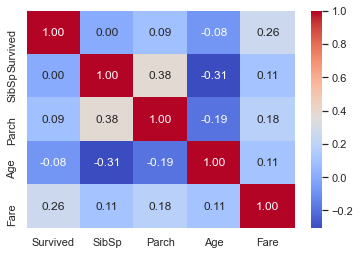

In [12]:
# 숫자형 변수 (SibSp, Parch, Age, Fare)와 Survived 간 상관계수행렬
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),
               annot=True, fmt='.2f',cmap='coolwarm')

Fare 변수만 생존률과 유의미한 상관관계를 가진다. <br>
다른 변수가 불필요하다는 의미는 아니다. 이런 변수들의 하위집단이 생존과 관련이 있을 수도 있다. 확인해보기 위해 변수를 자세히 살펴보자.

### SibSp

SibSp과 Survived의 관계를 살펴보자

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


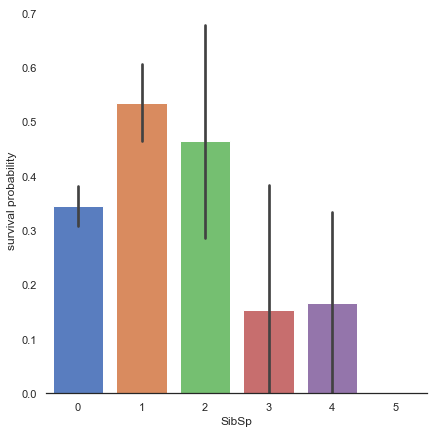

In [13]:
g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

형제자매/부모자녀가 많은 승객일수록 생존률이 낮아지는 것으로 보인다. 혼자인 승객 (0 SibSp) 이나 두 명의 가족이 있는 승객 (1 or 2 SibSp) 이 생존률이 더 높다. Feature Engineering에서 이 변수와 관련된 새로운 변수를 고려해볼 수 있겠다.

### Parch

Parch와 Survived의 관계를 살펴보자.

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


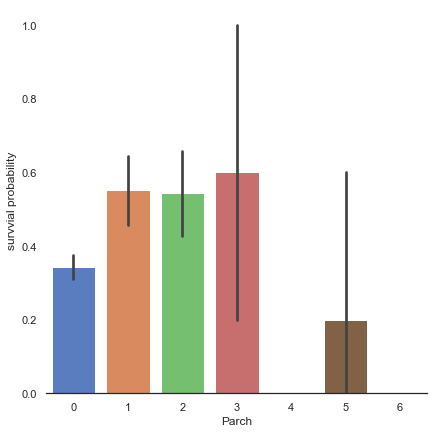

In [14]:
g = sns.factorplot(x='Parch',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survvial probability')

소가족이 생존률이 높고, 혼자(0 Parch)나 중간규모(3,4 Parch), 대규모가족(5,6 Parch)보다 더 높다. 하지만 3명의 부모/자녀가 있는 승객의 Survived의 표준편차는 중요해보인다.

### Age

Age와 Survived의 관계를 살펴보자.

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


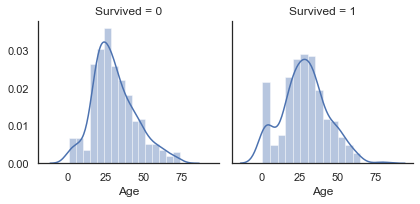

In [15]:
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot,'Age')

Age 가 Survived와 관련이 없어도 생존률이 더 높고 낮은 승객들의 나이 범주가 있음을 알 수 있다. 아주 어린 승객이 생존률이 높고 60~80대 승객이 생존률이 낮은 걸 볼 수 있다.

Age의 분포를 확인해보자.

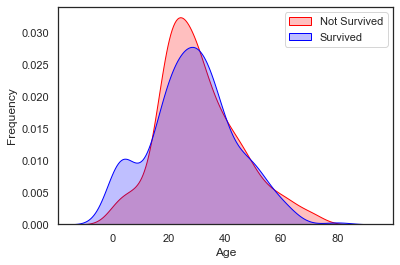

In [16]:
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())],
               color='Red',shade=True)   ### null 값이 아닌 사망자의 나이 확인
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())],
               ax=g, color='Blue', shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

두 밀도를 겹쳐놓으니 0~5세의 어린이의 생존률이 가장 높은 것을 볼 수 있다.

### Fare

In [17]:
dataset['Fare'].isnull().sum()

1

In [18]:
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

결측값이 하나 있지만, 예측에 중요하지 않을 것이므로 중위수로 대체한다.

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


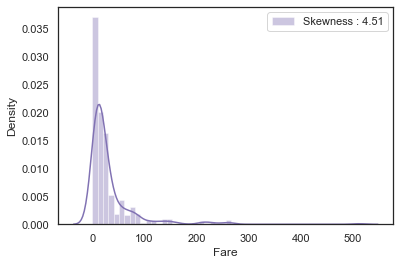

In [19]:
# Fare 분산 확인
g = sns.distplot(dataset['Fare'], color='m', label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

Fare의 분산이 굉장히 쏠려있다. scaling해도 모델에 안 좋은 영향을 줄 수 있습니다. 따라서 이 경우, 한 쪽으로 쏠린 왜도를 없애기 위해 로그함수를 취합니다.

In [20]:
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


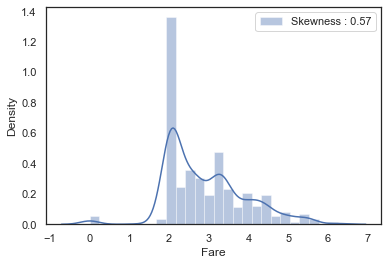

In [21]:
g = sns.distplot(dataset['Fare'], color='b',label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

로그 변환 후 쏠림 현상이 명확히 줄었다.

## 3.2. Categorical values

### Sex

Sex와 Survived의 관계를 살펴보자.

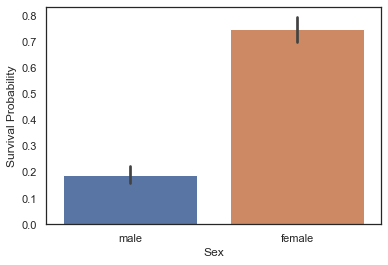

In [22]:
g = sns.barplot(x='Sex',y='Survived',data=train)
g = g.set_ylabel('Survival Probability')

In [23]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성이 여성보다 확실히 생존률이 더 낮다. 따라서 Sex는 생존률 예측에 중요한 역할을 할 것이다. 

### Pclass

Pclass 와 Survived의 관계를 살펴보자.

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


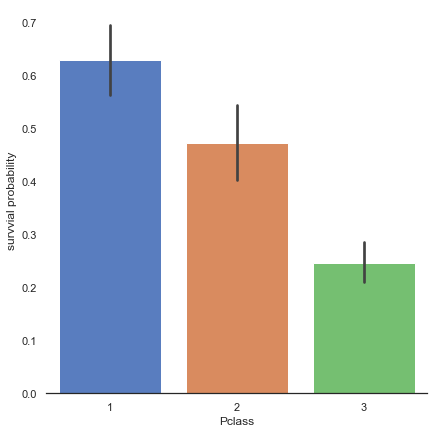

In [24]:
g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survvial probability')

Pclass 와 Survived를 Sex로 나눠 살펴보자.

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


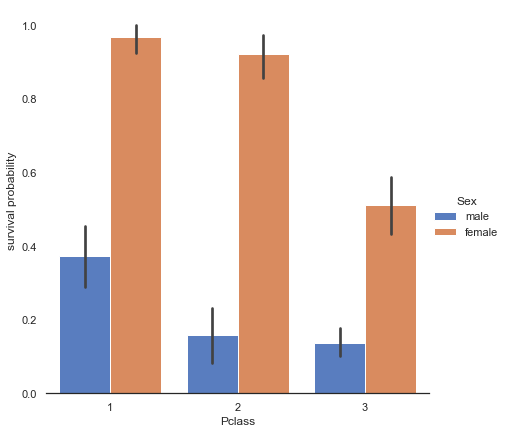

In [25]:
g = sns.factorplot(x='Pclass',y='Survived',hue='Sex',data=train,size=6,kind='bar',palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

생존률은 Pclass에 따라 다르다. Pclass1 승객은 Pclass2,3보다 생존률이 높다. 이 경향은 여성과 남성 승객 모두에게서 보인다.

### Embarked

In [26]:
dataset['Embarked'].isnull().sum()

2

In [27]:
dataset['Embarked'] = dataset['Embarked'].fillna('S')

2개의 결측치를 가장 많은 값인 S로 대체했다.

Embarked 와 Survived의 관계를 살펴보자.

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


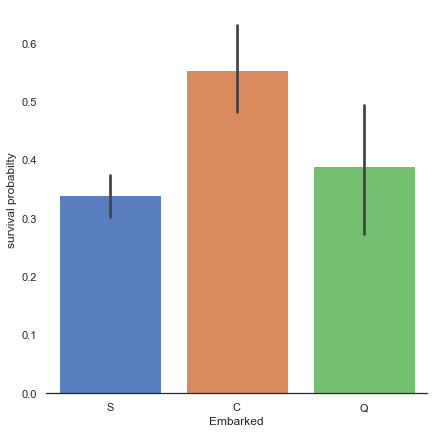

In [28]:
g = sns.factorplot(x='Embarked',y='Survived',data=train,size=6,kind='bar',palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probabilty')

항구 C (Cherbourg)에서 탑승한 승객이 생존률이 높다. Q(Queesntown)나 S(Southampton)보다 C에서 Pclass1 승객이 더 많았다고 가설을 세워볼 수 있다. <br>
그렇다면 Pclass와 Embarked의 관계를 살펴보자.

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3720: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


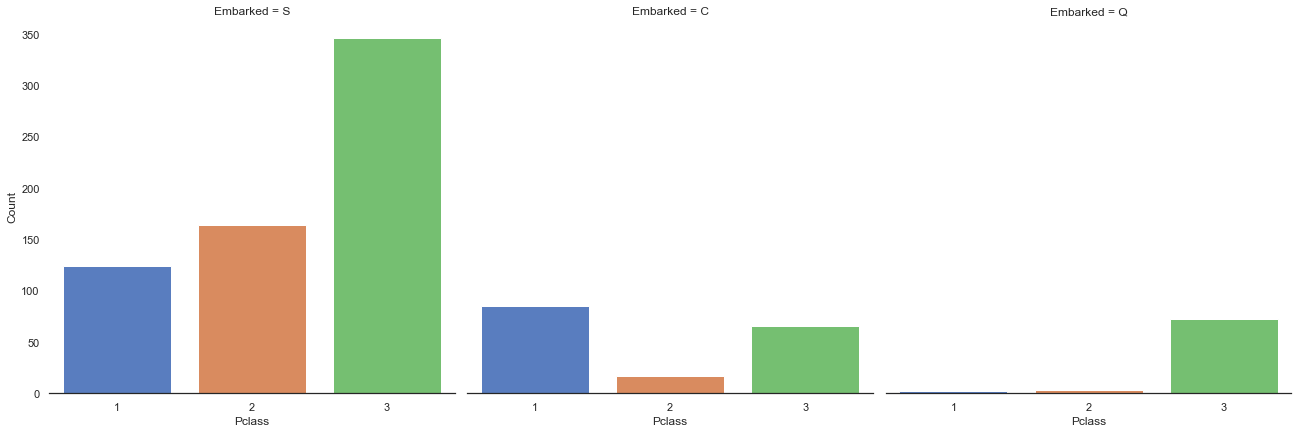

In [29]:
g = sns.factorplot('Pclass',col='Embarked',data=train,size=6,kind='count',palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

실제로 S와 Q에서 Pclass3의 승객이 많았고, 반면 C의 승객은 가장 생존률이 높은 Pclass1의 승객들이다. <br>
여기서 왜 Pclass1의 생존률이 더 높은지 설명할 수 없다. Pclass1의 승객은 그들의 영향으로 대피의 우선순위였을 것이라고 가설을 세울 수 있다.

# 4. Filling missing Values

## 4.1. Age

위에서 확인했듯이 전체 데이터셋에서 Age 변수의 결측치가 256개다. <br>
아이들과 같이 생존률이 높은 하위집단이 있었으므로 Age 변수를 유지하며 결측값을 대체한다. Age와 가장 상관관계가 높은 featrue (Sex, Parch, Pclass, SibSp)을 살펴보자.

c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)
c:\users\손시온\appdata\local\programs\python\python39\lib\site-packages\seaborn\categorical.py:3714: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `ki

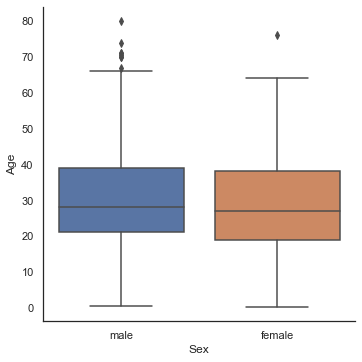

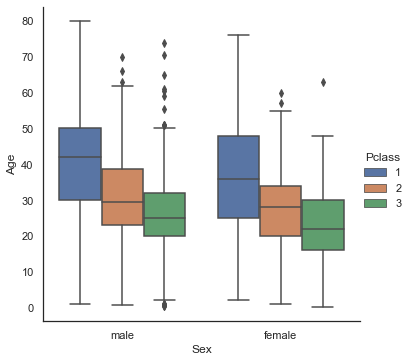

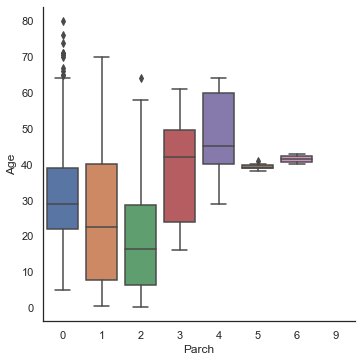

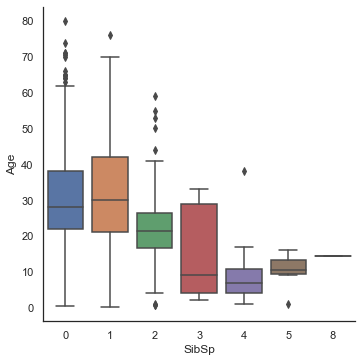

In [30]:
g = sns.factorplot(y='Age',x='Sex',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='Sex',hue='Pclass',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='Parch',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='SibSp',data=dataset,kind='box')

import warnings
warnings.filterwarnings('ignore')

- Age 분포는 성별간 유사하므로 Sex는 Age를 예측하는 데 무의미하다.
- PClass는 1,2,3 순으로 나이가 많다.
- 더 많은 부모/자녀와 함께할수록 나이가 많고, 나이가 적을수록 형제자매/배우자가 많다.

In [31]:
# Sex 범주화
dataset['Sex'] = dataset['Sex'].map({'male':0,'female':1})

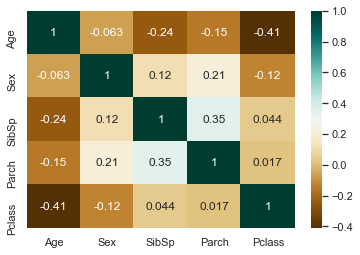

In [32]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),cmap='BrBG',annot=True)

Age는 Sex와 상관관계가 없고, Pclass, Parch, SibSp과 음의 상관관계가 있다. Parch의 그래프에서 부모/자녀 수에 따라 Age가 증가했지만 일반적으로는 음의 상관관계이다.
<br>따라서 SibSp, Parch, Pclass를 사용해 Age의 결측값을 대체한다. 이 변수들에 따라 비슷한 행의 중위값을 취한다.

In [33]:
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp'])
                              & (dataset['Parch']==dataset.iloc[i]['Parch'])
                              & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med
    
    """ age_pred는 결측값의 SibSp, Parch, Pclass의 모든 값과 같은 관측치가 있으면 
    그것들의 중위수를 취한 것.
    if문은 그렇게 취한 age_pred가 없으면, 즉 세 변수가 모두 같은 값이 없으면
    결측값을 걍 중위수로 대체하고(else) 값 있으면 age_pred로 대체하라는 것 """

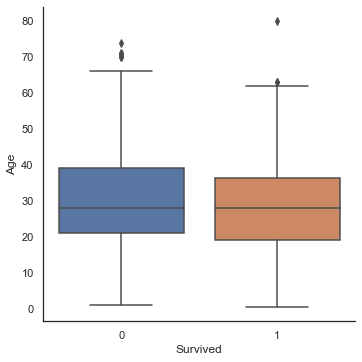

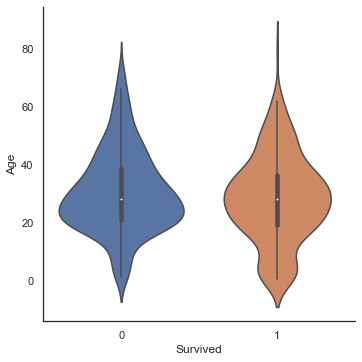

In [34]:
g = sns.factorplot(x='Survived',y='Age',data=train,kind='box')
g = sns.factorplot(x='Survived',y='Age',data=train,kind='violin')

사망자와 생존자 집단의 나이 중위수 값에 차이가 없다. 하지만 violin plot에서 아주 어린 승객이 생존률이 여전히 높은 것을 알 수 있다.

# 5. Feature engineering

## 5.1. Name/Title

In [35]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name 변수에는 탑승객의 직함 정보가 포함되어있다. 대피시 직함별 우선순위가 있었을 수도 있으므로 모델에 추가한다.

In [36]:
# Name에서 직함 추출
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

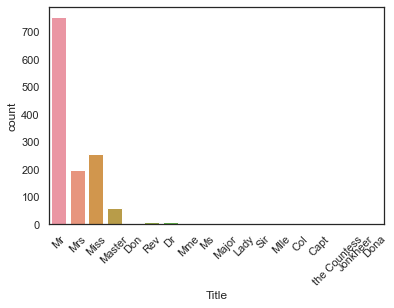

In [37]:
g = sns.countplot(x='Title',data=dataset)
g = plt.setp(g.get_xticklabels(), rotation=45)

17개의 직함이 있다. 대부분은 희귀하므로 4개의 범주로 나눠보자.

In [38]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0,'Miss':1,'Ms':1,'Mme':1,'Mlle':1,'Mrs':1,'Mr':2,'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

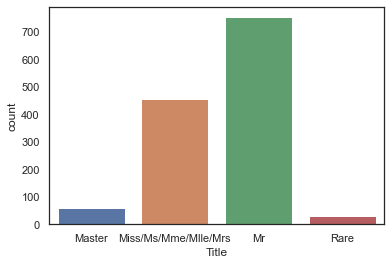

In [39]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

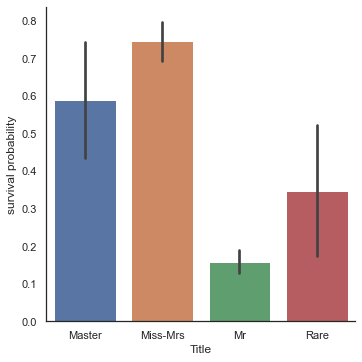

In [40]:
g = sns.factorplot(x='Title',y='Survived',data=dataset,kind='bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('survival probability')

In [41]:
# Name 변수 삭제
dataset.drop(labels=['Name'],axis=1,inplace=True)

## 5.2. Family size

대피 중 대가족은 형제자매나 부모를 찾으며 어려움이 많았을 것이다. 따라서 SibSp, Parch, 본인을 포함한 Fsize(Family Size) 변수를 생성한다.

In [42]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

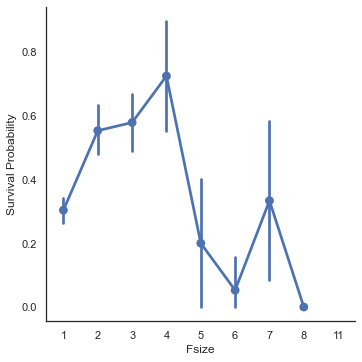

In [43]:
g = sns.factorplot(x='Fsize',y='Survived',data=dataset)
g = g.set_ylabels('Survival Probability')

가족 규모는 중요한 역할로 보인다. 대가족일수록 생존률이 낮다. 가족 규모를 4개의 범주로 나누어보겠다.

In [44]:
# 가족규모의 새로운 변수 생성
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

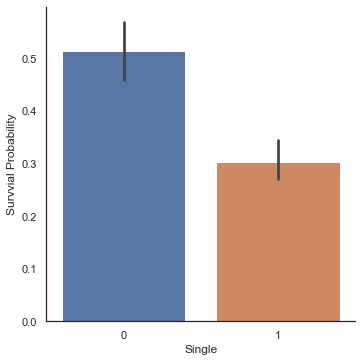

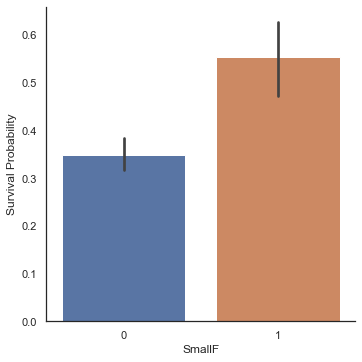

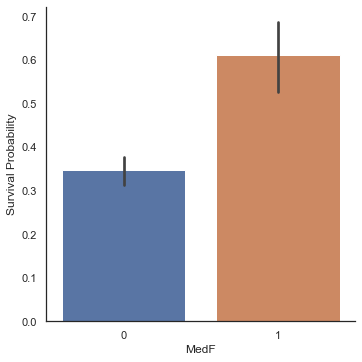

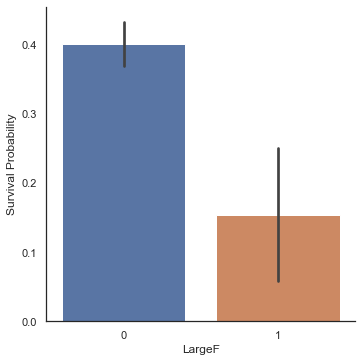

In [45]:
g = sns.factorplot(x='Single',y='Survived',data=dataset,kind='bar')
g = g.set_ylabels('Survvial Probability')

g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

가족규모에 따른 factorplot에서 소규모나 중간규모의 가족이 혼자나 대가족보다 생존률이 높은 것을 알 수 있다.

In [46]:
# Title과 Embarked one-hot encoding
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'],prefix='Em')

In [47]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3. Cabin

In [48]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [49]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [50]:
dataset['Cabin'].isnull().sum()

1007

Cabin 변수는 292개 값과 1007개의 결측치가 있다. 객실이 없는 승객은 객실 번호 대신 결측값을 가진 것이라고 추측할 수 있다.

In [51]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [52]:
# 결측값을 X로 대체, 나머지는 첫글자만 남김
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

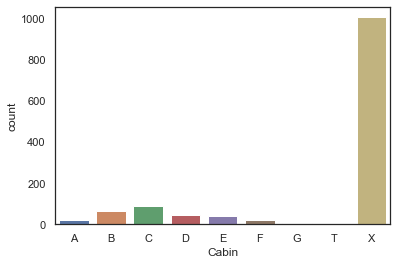

In [53]:
g = sns.countplot(dataset['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

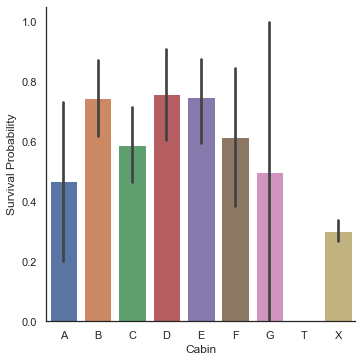

In [54]:
g = sns.factorplot(y='Survived',x='Cabin',data=dataset,kind='bar',order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

객실이 있는 승객 수가 적어 생존률을 구별할 수 없다. 하지만 일반적으로 객실이 있는 승객이 없는 승객(X)보다 생존률이 높다는 것을 알 수 있다. 특히 B,C,D,E,F가 그렇다.

In [55]:
dataset = pd.get_dummies(dataset,columns=['Cabin'],prefix='Cabin')

## 5.4. Ticket

In [56]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

접두사가 같은 티켓이 같은 객실에 예약될 수 있다. 동일한 접두사를 가진 티켓은 유사한 Pclass와 생존률을 가질지도 모른다. 따라서 Ticket 변수를 접두사로 대체한다. 

In [57]:
# 접두사를 추출해 Ticket 변수 처리. 접두사가 없으면 X 반환
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])  #접두사 추출
    else:
        Ticket.append('X')
            
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [58]:
dataset = pd.get_dummies(dataset,columns=['Ticket'],prefix='T')

In [59]:
# Pclass 변수 one-hot encoding
dataset['Pclass'] = dataset['Pclass'].astype('category')
datasest = pd.get_dummies(dataset,columns=['Pclass'],prefix='Pc')

In [60]:
# 불필요한 변수 제거
dataset.drop(labels=['PassengerId'],axis=1,inplace=True)

In [61]:
dataset.head

<bound method NDFrame.head of       Survived Pclass  Sex   Age  SibSp  Parch      Fare  Fsize  Single  \
0          0.0      3    0  22.0      1      0  1.981001      2       0   
1          1.0      1    1  38.0      1      0  4.266662      2       0   
2          1.0      3    1  26.0      0      0  2.070022      1       1   
3          1.0      1    1  35.0      1      0  3.972177      2       0   
4          0.0      3    0  35.0      0      0  2.085672      1       1   
...        ...    ...  ...   ...    ...    ...       ...    ...     ...   
1294       NaN      3    0  25.0      0      0  2.085672      1       1   
1295       NaN      1    1  39.0      0      0  4.690430      1       1   
1296       NaN      3    0  38.5      0      0  1.981001      1       1   
1297       NaN      3    0  25.0      0      0  2.085672      1       1   
1298       NaN      3    0  16.0      1      1  3.107198      3       0   

      SmallF  ...  T_SOTONO2  T_SOTONOQ  T_SP  T_STONO  T_STONO2  T_S

# 6. Modeling

In [62]:
# train, test 분리
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'],axis=1,inplace=True)

In [63]:
# train 변수와 target 분리
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'],axis=1)

## 6.1. Simple modeling

10개의 인기있는 분류기를 비교해 kfold 교차검증으로 각 정확도의 평균을 평가한다.
- SVC / Decision Tree / AdaBoost / Random Forest / Extra Trees / Gradient Boosting / Multiple layer perceptron(neural network) / KNN / Logistic regression / Linear Discriminant Analysis

In [64]:
# Kfold 교차검증 모델
kfold = StratifiedKFold(n_splits=10)

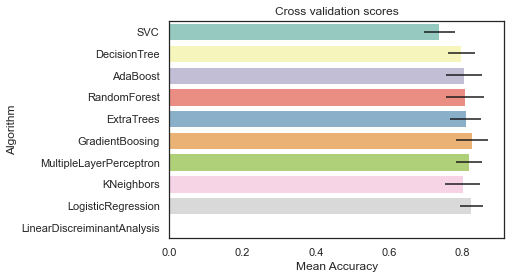

In [84]:
# 10개의 알고리즘 모델링
random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, 
                                      scoring = 'accuracy', cv = kfold))
                                                ### n_jobs=4는 unicode에러로 삭제
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans':cv_means,'CrossValerrors':cv_std,
                      'Algorithm':['SVC','DecisionTree','AdaBoost','RandomForest','ExtraTrees',
                                  'GradientBoosing','MultipleLayerPerceptron','KNeighbors',
                                  'LogisticRegression','LinearDiscreiminantAnalysis']})

g = sns.barplot('CrossValMeans','Algorithm',data=cv_res,palette='Set3',orient='h',**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 선택한다.

### 6.1.2. Hyperparameter tunning for best models

AdaBoost, ExtraTree, RandomForest, GradientBoosting, SVC 분류기에 대해 최적화했다. 원본에는 cpu가 4개여서 n_jobs=4로 설정되어있지만 UnicodeEncodeError로 삭제했다. 하지만 n_jobs를 설정하면 시간이 오래걸린다.

#### Adaboost

In [87]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid=ada_param_grid,cv=kfold,scoring='accuracy',verbose=1)
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [88]:
gsadaDTC.best_score_

0.8162282941777323

#### ExtraTrees

In [90]:
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid=ex_param_grid,cv=kfold,scoring='accuracy',verbose=1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8342696629213483

#### RandomForestClassifier

In [91]:
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid=rf_param_grid,cv=kfold,scoring='accuracy',verbose=1)
gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8354315628192033

#### Gradient boosting

In [92]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring='accuracy', verbose = 1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8297242083758938

#### SCV

In [96]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", verbose = 1)
gsSVMC.fit(X_train,Y_train)
SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8342696629213483

### 6.1.3. Plot learning curves

Lerning curve는 training set의 과적합 효과와 training 크기가 정확도에 미치는 영향을 확인할 수 있는 좋은 방법이다.

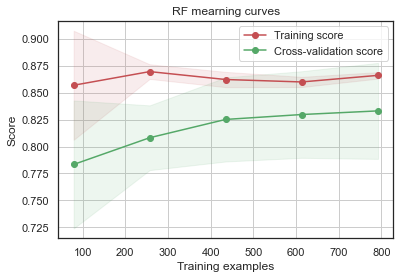

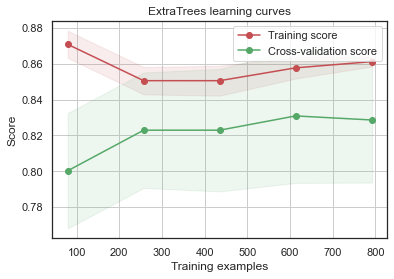

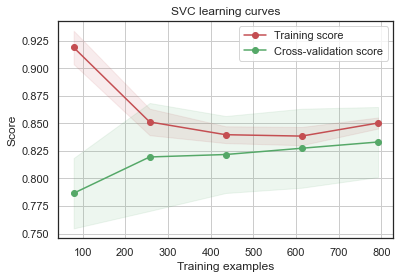

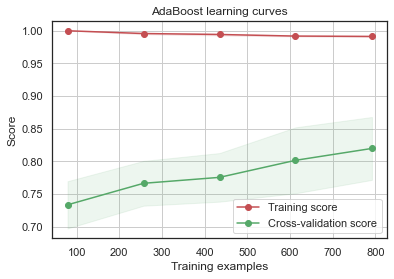

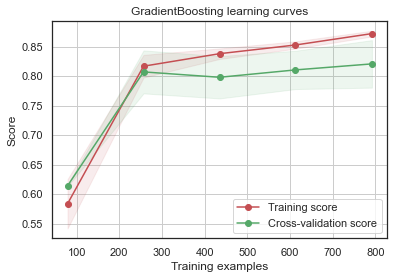

In [98]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1,1.0,5)):
    # test와 trainig의 학습곡선에 대한 간단한 그래프
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes,train_scores,test_scores = learning_curve(
    estimator,X,y,cv=cv,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,train_scores_mean - train_scores_std,
                    train_scores_mean+train_scores_std, alpha=0.1,color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color="r", label='Training score')
    plt.plot(train_sizes,test_scores_mean,'o-',color="g", label='Cross-validation score')
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,'RF mearning curves',X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,'ExtraTrees learning curves',X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,'SVC learning curves',X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,'AdaBoost learning curves',X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,'GradientBoosting learning curves',X_train,Y_train,cv=kfold)

GradientBoosting과 Adaboost 분류기는 trainig set에 과적합하는 경향이 있다. 하지만 Cross validation score의 그래프가 증가하는 것으로 보아 training 데이터를 더 많이 학습시키면 성능이 더 좋아질 수도 있다. <br>
SCV와 ExtraTree 분류기는 training 곡선과 cross validations 곡선이 밀접하므로 예측을 잘 일반화시킨다고 볼 수 있다.

### 6.1.4. Feature importance of tree based classifiers

생존률 예측에 가장 중요한 변수를 보기 위해 4개의 트리 기반 분류기에 변수 중요도를 확인해보자.

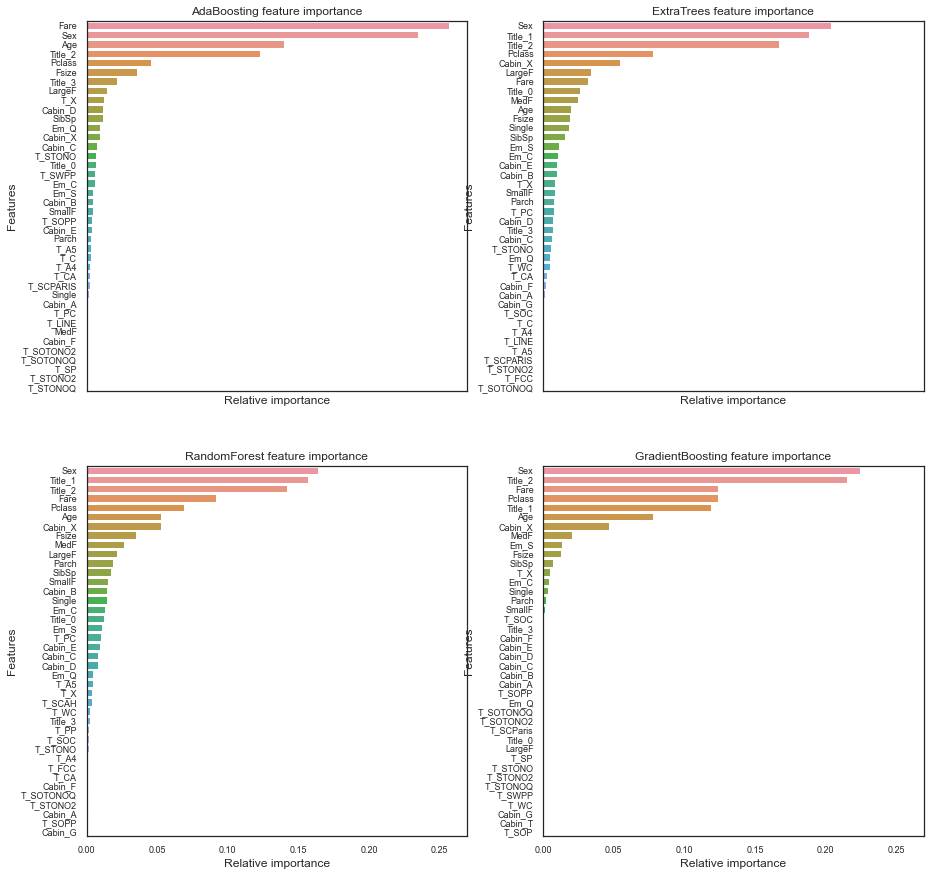

In [100]:
nrows = ncols = 2
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,sharex='all',figsize=(15,15))

names_classifiers = [('AdaBoosting',ada_best),('ExtraTrees',ExtC_best),('RandomForest',RFC_best),('GradientBoosting',GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],
                       x=classifier.feature_importances_[indices][:40],
                       orient='h',ax=axes[row][col])
        g.set_xlabel('Relative importance',fontsize=12)
        g.set_ylabel('Features',fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+' feature importance')
        nclassifier += 1

4개의 트리 기반 분류기 Adaboost, ExtraTree, RandomForest, GradientBoosting에 대한 변수 중요도를 알아봤다. 상대적 중요도에 따라 상위 변수가 달라진다. 이는 그 예측들이 같은 변수에 기반하지 않는다는 것을 의미한다. 하지만 Fare, Title_2, Age, Sex와 같은 중요한 변수는 공통된다. Title_2는 Ms/Mlle/Mme/Miss/Ms 를 나타내고 Sex와 상관관계가 높다.
- Pc_1, Pc_2, Pc_3, Fare : 사회적 지위
- Sex, Title_2, Title_3 : 성별
- Age, Title_1 : 나이
- Fsize, LargeF, MedF, Single : 가족 규모

4개의 분류기에서 본 변수 중요도에 따르면, 생존률은 배 안에서 승객의 위치보다 승객들의 연령, 성별, 가족 규모, 사회직 지위 등과 더 관련이 있다.

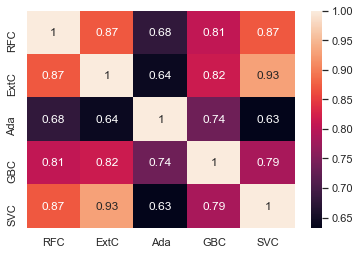

In [101]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# 모든 분류기의 결과 연결
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

AdaBoost와 다른 분류기의 비교를 제외하고는, 5개의 분류기가 예측을 꽤 비슷하게 한 것으로 보인다. 하지만 약간의 차이가 있으므로 ensembling vote를 충분히 고려할만하다.

## 6.2. Ensemble modeling

### 6.2.1. Combining models

5개의 분류기의 예측을 조합하기 위해 Voting Classifier를 사용한다. 각 vote의 확률을 고려해 voting parameter에 'soft'한 결과를 전달한다.

In [103]:
votingC = VotingClassifier(estimators=[('rfc',RFC_best),('extc',ExtC_best),
                                      ('svc',SVMC_best),('adac',ada_best),
                                      ('gbc',GBC_best)],voting='soft')
votingC = votingC.fit(X_train,Y_train)

## 6.3. Prediction

### 6.3.1. Predict and Submit results

In [104]:
test_Survived = pd.Series(votingC.predict(test),name='Survived')
results = pd.concat([IDtest,test_Survived],axis=1)
results.to_csv('ensemble_python_voting.csv',index=False)

# 2nd

# 1. Introduction

main parts :
- Feature analysis
- Feature engineering
- Modeling

In [156]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from collections import Counter

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

sns.set(style='white',context='notebook',palette='deep')

# 2. Load and check data

## 2.1. Load data

In [157]:
train = pd.read_csv("../input/train.csv")
test = pd.read_csv("../input/test.csv")
IDtest = test["PassengerId"]

## 2.2. Outlier detection

In [158]:
def detect_outliers(df,n,features):
    """ featrue의 dataframe을 사용하고 
    Tukey방법에 따라 outlier가 n개 이상인 관측치의 인덱스 목록을 반환 """
    outlier_indices = []
    
    # feature의 columns 반복
    for col in features:
        # 1사분위수(25%)
        Q1 = np.percentile(df[col],25)
        # 3사분위수(75%)
        Q3 = np.percentile(df[col],75)
        # IQR (Interquartile range)
        IQR = Q3 - Q1
        
        # outlier step
        outlier_step = 1.5*IQR
        
        # feature columns의 outlier 인덱스 목록 저장
        outlier_list_col = df[(df[col]<Q1-outlier_step) | (df[col]>Q3+outlier_step)].index
        
        # 추출한 oiutlier의 인덱스 목록을 outlier_indices 변수에 추가
        outlier_indices.extend(outlier_list_col)
        
    # outlier가 n개 이상인 관측치 선택
    outlier_indices = Counter(outlier_indices)
    multiple_outliers = list(k for k, v in outlier_indices.items() if v>n)
        
    return multiple_outliers
    
# Age, SibSp, Parce, Fare 변수에서 outlier 색출
Outliers_to_drop = detect_outliers(train,2,['Age','SibSp','Parch','Fare'])

outlier는 예측(특히 회귀 문제에서)에 극적인 영향을 줄 수 있으므로 outlier를 처리해야한다.

Tukey 방법으로 분포 값의 1사분위수와 3사분위수의 차이인 IQR(사분위간 범위)를 정의해 outlier를 색출했다. outlier는 IQR +- outlier step 값 외의 행이다.

숫자형 변수인 Age, SibSp, Sarch, Fare의 outlier를 추출하기 위해 outlier를 최소 2개 이상의 outlied된 숫자값이 있는 행으로 간주했다.

In [159]:
train.loc[Outliers_to_drop]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.00,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.00,C23 C25 C27,S
159,160,0,3,"Sage, Master. Thomas Henry",male,NaN,8,2,CA. 2343,69.55,NaN,S
180,181,0,3,"Sage, Miss. Constance Gladys",female,NaN,8,2,CA. 2343,69.55,NaN,S
201,202,0,3,"Sage, Mr. Frederick",male,NaN,8,2,CA. 2343,69.55,NaN,S
324,325,0,3,"Sage, Mr. George John Jr",male,NaN,8,2,CA. 2343,69.55,NaN,S
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.00,C23 C25 C27,S
792,793,0,3,"Sage, Miss. Stella Anna",female,NaN,8,2,CA. 2343,69.55,NaN,S
846,847,0,3,"Sage, Mr. Douglas Bullen",male,NaN,8,2,CA. 2343,69.55,NaN,S
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.55,NaN,S


10개의 outlier를 검출했다. 28, 89, 342 승객은 Fare가 너무 높고, 나머지 7명의 승객은 SibSp가 너무 높다.

In [160]:
# outlier 삭제
train = train.drop(Outliers_to_drop, axis=0).reset_index(drop=True)

## 2.3. joining train and test set

In [161]:
train_len = len(train)
dataset = pd.concat(objs=[train,test], axis=0).reset_index(drop=True)

범주형 변환 중 같은 수의 feature를 얻기 위해 train, test 데이터셋을 합쳤다.

## 2.4. check for null and missing values

In [162]:
# 비어있는 값을 NaN값으로 채우기
dataset = dataset.fillna(np.nan)

# Null값 확인
dataset.isnull().sum()

PassengerId       0
Survived        418
Pclass            0
Name              0
Sex               0
Age             256
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1007
Embarked          2
dtype: int64

Age와 Cabin은 결측값 중 중요한 부분이다. Survived의 결측값은 join된 test 데이터셋에 해당해 NaN값으로 대체되었다.

In [163]:
train.info()
train.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 881 entries, 0 to 880
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  881 non-null    int64  
 1   Survived     881 non-null    int64  
 2   Pclass       881 non-null    int64  
 3   Name         881 non-null    object 
 4   Sex          881 non-null    object 
 5   Age          711 non-null    float64
 6   SibSp        881 non-null    int64  
 7   Parch        881 non-null    int64  
 8   Ticket       881 non-null    object 
 9   Fare         881 non-null    float64
 10  Cabin        201 non-null    object 
 11  Embarked     879 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 82.7+ KB


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            170
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          680
Embarked         2
dtype: int64

In [164]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [165]:
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [166]:
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,881.000000,881.000000,881.000000,711.000000,881.000000,881.000000,881.000000
mean,446.713961,0.385925,2.307605,29.731603,0.455165,0.363224,31.121566
std,256.617021,0.487090,0.835055,14.547835,0.871571,0.791839,47.996249
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,226.000000,0.000000,2.000000,20.250000,0.000000,0.000000,7.895800
50%,448.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.000000,1.000000,3.000000,38.000000,1.000000,0.000000,30.500000
max,891.000000,1.000000,3.000000,80.000000,5.000000,6.000000,512.329200


# 3. Feature analysis

## 3.1. Numerical values

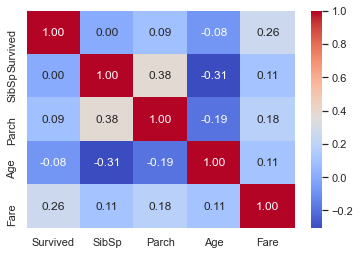

In [61]:
# 숫자형 변수 (SibSp, Parch, Age, Fare)와 Survived 간 상관계수행렬
g = sns.heatmap(train[['Survived','SibSp','Parch','Age','Fare']].corr(),
               annot=True, fmt='.2f', cmap='coolwarm')

Fare 변수만 생존률과 유의미한 상관관계를 가진다.
다른 변수가 불필요하다는 의미는 아니다. 이런 변수들의 하위집단이 생존과 관련이 있을 수도 있다. 확인해보기 위해 변수를 자세히 살펴보자.

### SibSp

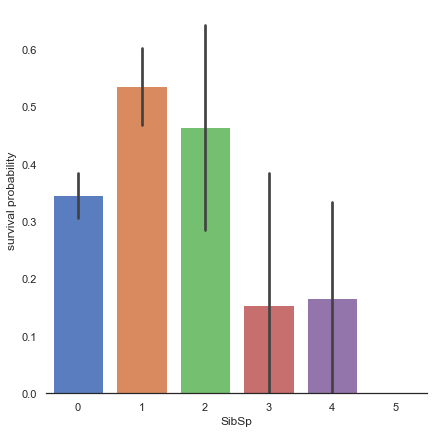

In [63]:
import warnings
warnings.filterwarnings('ignore')  ### 임의로 warning 무시 코드 추가

# Survived와 SibSp의 관계
g = sns.factorplot(x='SibSp',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

형제자매/부모자녀가 많은 승객일수록 생존률이 낮아지는 것으로 보인다. 혼자인 승객 (0 SibSp) 이나 두 명의 가족이 있는 승객 (1 or 2 SibSp) 이 생존률이 더 높다. Feature Engineering에서 이 변수와 관련된 새로운 변수를 고려해볼 수 있겠다.

### Parch

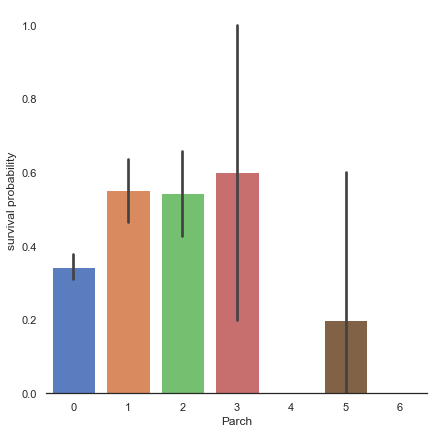

In [64]:
# Survived와 Parch의 관계
g = sns.factorplot(x='Parch',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

소가족이 생존률이 높고, 혼자(0 Parch)나 중간규모(3,4 Parch), 대규모가족(5,6 Parch)보다 더 높다. 하지만 3명의 부모/자녀가 있는 승객의 Survived의 표준편차는 중요해보인다.

### Age

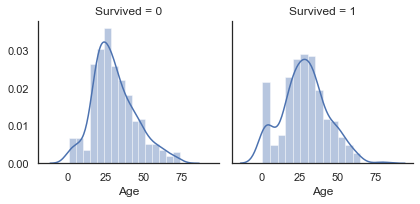

In [66]:
# Survived 와 Age의 관계
g = sns.FacetGrid(train, col='Survived')
g = g.map(sns.distplot,'Age')

Age 가 Survived와 관련이 없어도 생존률이 더 높고 낮은 승객들의 나이 범주가 있음을 알 수 있다. 아주 어린 승객이 생존률이 높고 60~80대 승객이 생존률이 낮은 걸 볼 수 있다.

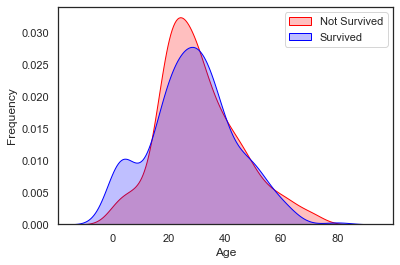

In [67]:
# Age 분포 확인
g = sns.kdeplot(train['Age'][(train['Survived']==0) & (train['Age'].notnull())],
               color='Red',shade=True)
g = sns.kdeplot(train['Age'][(train['Survived']==1) & (train['Age'].notnull())],
               color='Blue',shade=True)
g.set_xlabel('Age')
g.set_ylabel('Frequency')
g = g.legend(['Not Survived','Survived'])

두 밀도를 겹쳐놓으니 0~5세의 어린이의 생존률이 가장 높은 것을 볼 수 있다.

### Fare

In [68]:
dataset['Fare'].isnull().sum()

1

In [167]:
# 결측값을 중위수로 대체
dataset['Fare'] = dataset['Fare'].fillna(dataset['Fare'].median())

결측값이 하나 있지만, 예측에 중요하지 않을 것이므로 중위수로 대체한다.

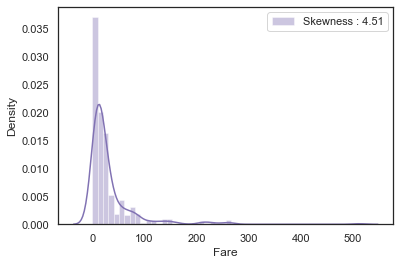

In [71]:
# Fare 분산 확인
g = sns.distplot(dataset['Fare'],color='m',label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

Fare의 분산이 굉장히 쏠려있다. scaling해도 모델에 안 좋은 영향을 줄 수 있다. 따라서 이 경우, 한 쪽으로 쏠린 왜도를 없애기 위해 로그함수를 취한다.

In [168]:
# Fare에 로그함수 취하기
dataset['Fare'] = dataset['Fare'].map(lambda i: np.log(i) if i>0 else 0)

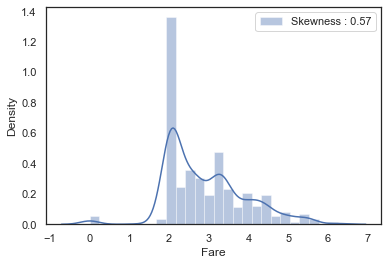

In [73]:
g = sns.distplot(dataset['Fare'],color='b',label='Skewness : %.2f'%(dataset['Fare'].skew()))
g = g.legend(loc='best')

로그 변환 후 쏠림 현상이 명확히 줄었다.

## 3.2. Categorical values

### Sex

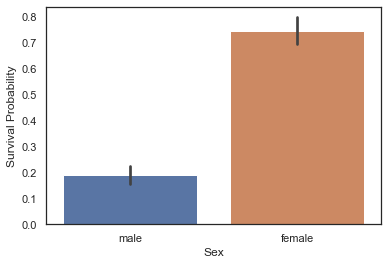

In [74]:
g = sns.barplot(x='Sex',y='Survived',data=train)
g = g.set_ylabel('Survival Probability')

In [75]:
train[['Sex','Survived']].groupby('Sex').mean()

,Survived
Sex,
female,0.747573
male,0.190559


남성이 여성보다 확실히 생존률이 더 낮다. 따라서 Sex는 생존률 예측에 중요한 역할을 할 것이다.

### Pclass

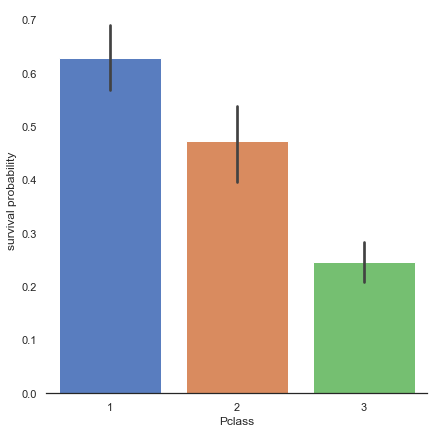

In [76]:
# Survived와 Pclass의 관계
g = sns.factorplot(x='Pclass',y='Survived',data=train,kind='bar',size=6,palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

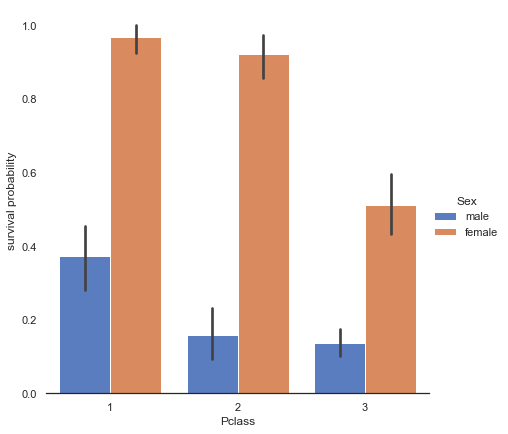

In [77]:
# Sex 별 Pclass와 Survived의 관계
g = sns.factorplot(x='Pclass',y='Survived',hue='Sex',data=train,size=6,kind='bar',palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

생존률은 Pclass에 따라 다르다. Pclass1 승객은 Pclass2,3보다 생존률이 높다. 이 경향은 여성과 남성 승객 모두에게서 보인다.

### Embarked

In [78]:
dataset['Embarked'].isnull().sum()

2

In [169]:
# Embarked 의 결측값을 최빈값 S로 대체
dataset['Embarked'] = dataset['Embarked'].fillna('S')

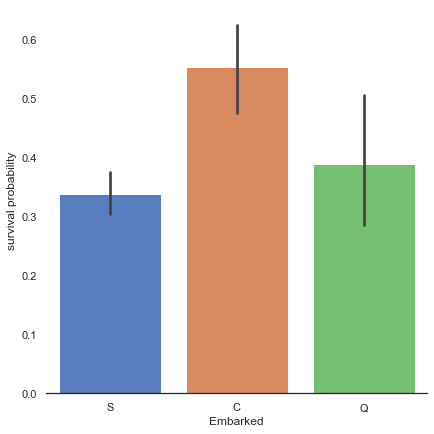

In [80]:
# Survived 와 Embarked 의 관계
g = sns.factorplot(x='Embarked',y='Survived',data=train,size=6,kind='bar',palette='muted')
g.despine(left=True)
g = g.set_ylabels('survival probability')

항구 C (Cherbourg)에서 탑승한 승객이 생존률이 높다. Q(Queesntown)나 S(Southampton)보다 C에서 Pclass1 승객이 더 많았다고 가설을 세워볼 수 있다.
그렇다면 Pclass와 Embarked의 관계를 살펴보자.

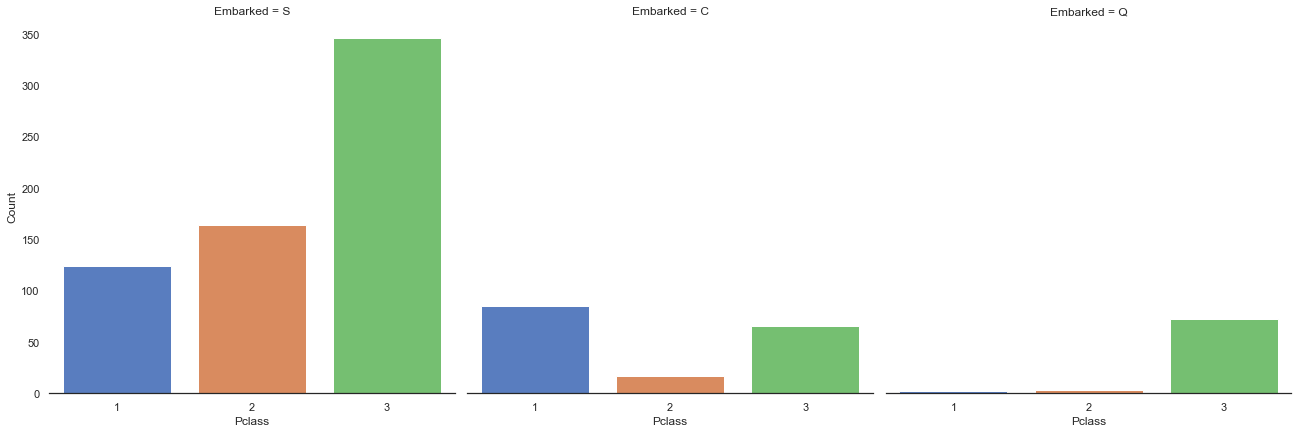

In [81]:
# Embarked 와 Pclass의 관계
g = sns.factorplot('Pclass',col='Embarked',data=train,size=6,kind='count',palette='muted')
g.despine(left=True)
g = g.set_ylabels('Count')

실제로 S와 Q에서 Pclass3의 승객이 많았고, 반면 C의 승객은 가장 생존률이 높은 Pclass1의 승객들이다.
여기서 왜 Pclass1의 생존률이 더 높은지 설명할 수 없다. Pclass1의 승객은 그들의 영향으로 대피의 우선순위였을 것이라고 가설을 세울 수 있다.

# 4. Filling missing Values

## 4.1. Age

위에서 확인했듯이 전체 데이터셋에서 Age 변수의 결측치가 256개다.
아이들과 같이 생존률이 높은 하위집단이 있었으므로 Age 변수를 유지하며 결측값을 대체한다. Age와 가장 상관관계가 높은 featrue (Sex, Parch, Pclass, SibSp)을 살펴보자.

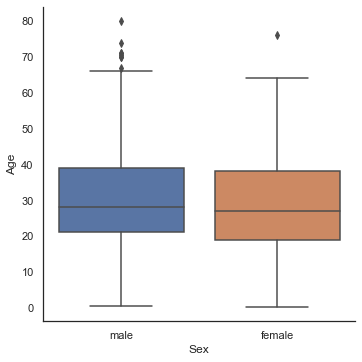

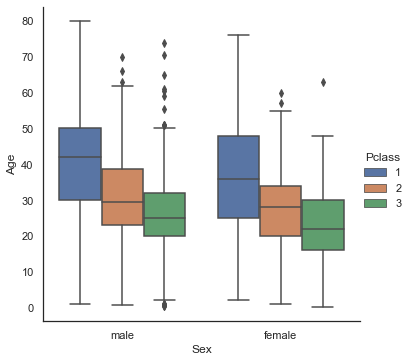

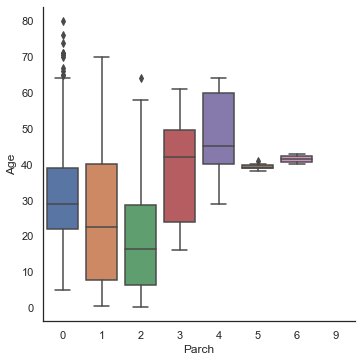

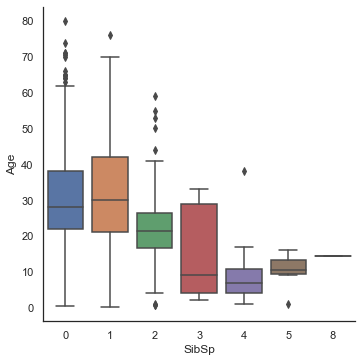

In [82]:
# Sex, Parch, Pclass, SibSp 와 Age의 관계
g = sns.factorplot(y='Age',x='Sex',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='Sex',hue='Pclass',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='Parch',data=dataset,kind='box')
g = sns.factorplot(y='Age',x='SibSp',data=dataset,kind='box')

- Age 분포는 성별간 유사하므로 Sex는 Age를 예측하는 데 무의미하다.
- PClass는 1,2,3 순으로 나이가 많다.
- 더 많은 부모/자녀와 함께할수록 나이가 많고, 나이가 적을수록 형제자매/배우자가 많다.

In [170]:
# Sex 범주화
dataset['Sex'] = dataset['Sex'].map({'male':0,'female':1})

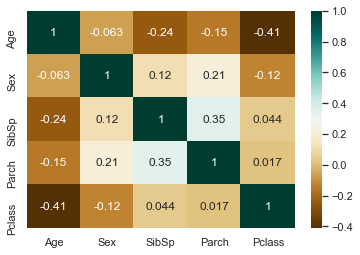

In [171]:
g = sns.heatmap(dataset[['Age','Sex','SibSp','Parch','Pclass']].corr(),
               cmap='BrBG',annot=True)

Age는 Sex와 상관관계가 없고, Pclass, Parch, SibSp과 음의 상관관계가 있다. Parch의 그래프에서 부모/자녀 수에 따라 Age가 증가했지만 일반적으로는 음의 상관관계이다. <br>
따라서 SibSp, Parch, Pclass를 사용해 Age의 결측값을 대체한다. 이 변수들에 따라 비슷한 행의 중위값을 취한다.

In [172]:
# Pclass, Parch, SibSp을 이용한 Age 결측값 채우기
index_NaN_age = list(dataset['Age'][dataset['Age'].isnull()].index)

for i in index_NaN_age:
    age_med = dataset['Age'].median()
    age_pred = dataset['Age'][((dataset['SibSp']==dataset.iloc[i]['SibSp'])
                              & (dataset['Parch']==dataset.iloc[i]['Parch'])
                              & (dataset['Pclass']==dataset.iloc[i]['Pclass']))].median()
    if not np.isnan(age_pred) :
        dataset['Age'].iloc[i] = age_pred
    else:
        dataset['Age'].iloc[i] = age_med
    
    ### age_pred는 결측값의 SibSp, Parch, Pclass의 모든 값과 같은 관측치가 있으면 
    ### 그것들의 중위수를 취한 것.
    ### if문은 그렇게 취한 age_pred가 없으면, 즉 세 변수가 모두 같은 값이 없으면
    ### 결측값을 걍 중위수로 대체하고(else) 값 있으면 age_pred로 대체하라는 것

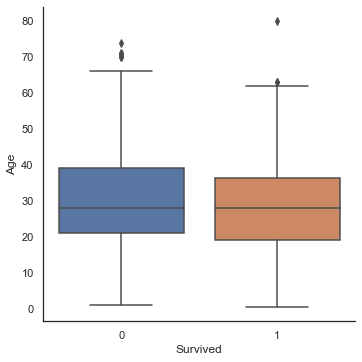

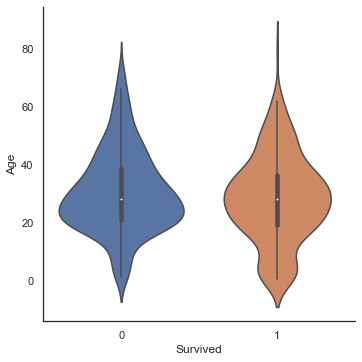

In [89]:
g = sns.factorplot(x='Survived',y='Age',data=train,kind='box')
g = sns.factorplot(x='Survived',y='Age',data=train,kind='violin')

사망자와 생존자 집단의 나이 중위수 값에 차이가 없다. 하지만 violin plot에서 아주 어린 승객이 생존률이 여전히 높은 것을 알 수 있다.

# 5. Feature engineering

## 5.1. Name/Title

In [90]:
dataset['Name'].head()

0                              Braund, Mr. Owen Harris
1    Cumings, Mrs. John Bradley (Florence Briggs Th...
2                               Heikkinen, Miss. Laina
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                             Allen, Mr. William Henry
Name: Name, dtype: object

Name 변수에는 탑승객의 직함 정보가 포함되어있다. 대피시 직함별 우선순위가 있었을 수도 있으므로 모델에 추가한다.

In [173]:
# Name에서 직함 추출
dataset_title = [i.split(',')[1].split('.')[0].strip() for i in dataset['Name']]
### strip : 인자 안의 문자열을 원문자열의 양쪽에서 제거, 여기선 해당 문자열 제외 제거
dataset['Title'] = pd.Series(dataset_title)
dataset['Title'].head()

0      Mr
1     Mrs
2    Miss
3     Mrs
4      Mr
Name: Title, dtype: object

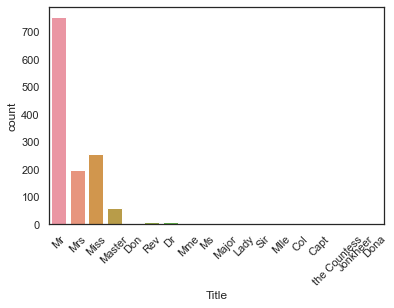

In [93]:
g = sns.countplot(x='Title',data=dataset)
g = plt.setp(g.get_xticklabels(),rotation=45)

17개의 직함이 있다. 대부분은 희귀하므로 4개의 범주로 나눠보자.

In [174]:
dataset['Title'] = dataset['Title'].replace(['Lady', 'the Countess','Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'],'Rare')
dataset['Title'] = dataset['Title'].map({'Master':0,'Miss':1,'Ms':1,'Mme':1,'Mlle':1,'Mrs':1,'Mr':2,'Rare':3})
dataset['Title'] = dataset['Title'].astype(int)

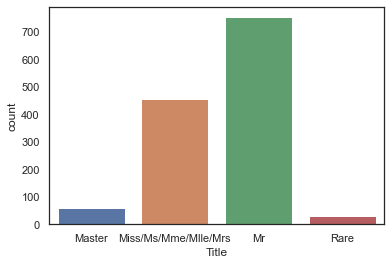

In [175]:
g = sns.countplot(dataset['Title'])
g = g.set_xticklabels(['Master','Miss/Ms/Mme/Mlle/Mrs','Mr','Rare'])

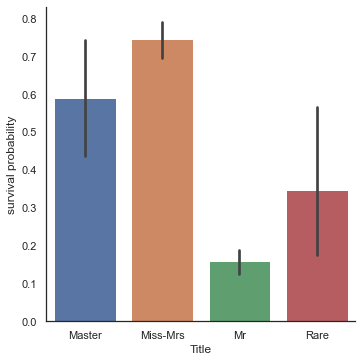

In [96]:
g = sns.factorplot(x='Title',y='Survived',data=dataset,kind='bar')
g = g.set_xticklabels(['Master','Miss-Mrs','Mr','Rare'])
g = g.set_ylabels('survival probability')

In [176]:
# Name 변수 삭제
dataset.drop(labels=['Name'],axis=1,inplace=True)

### inplace=True 기능 (Fasle가 기본값)
### df.func(inplace=True) : 원래 df가 func에 의해 함께 바뀜
### df=df.func(inplace=False) : 원래 df는 그대로이고 복사된 것만 바뀜

## 5.2. Family size

대피 중 대가족은 형제자매나 부모를 찾으며 어려움이 많았을 것이다. 따라서 SibSp, Parch, 본인을 포함한 Fsize(Family Size) 변수를 생성한다.

In [177]:
dataset['Fsize'] = dataset['SibSp'] + dataset['Parch'] + 1

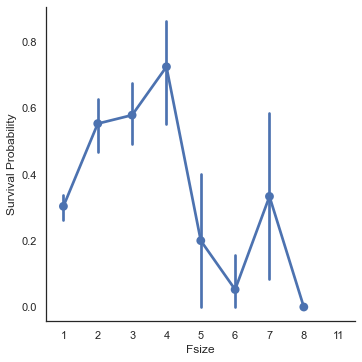

In [101]:
g = sns.factorplot(x='Fsize',y='Survived',data=dataset)
g = g.set_ylabels('Survival Probability')

가족 규모는 중요한 역할로 보인다. 대가족일수록 생존률이 낮다. 가족 규모를 4개의 범주로 나누어보겠다.

In [178]:
dataset['Single'] = dataset['Fsize'].map(lambda s: 1 if s==1 else 0)
dataset['SmallF'] = dataset['Fsize'].map(lambda s: 1 if s==2 else 0)
dataset['MedF'] = dataset['Fsize'].map(lambda s: 1 if 3<=s<=4 else 0)
dataset['LargeF'] = dataset['Fsize'].map(lambda s: 1 if s>=5 else 0)

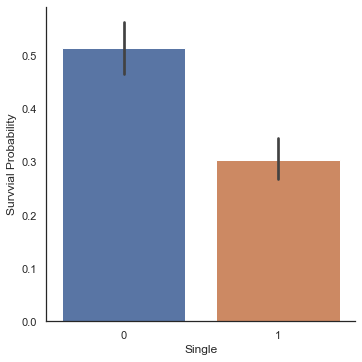

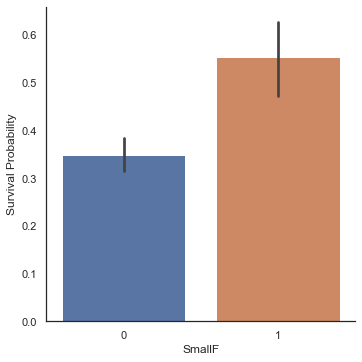

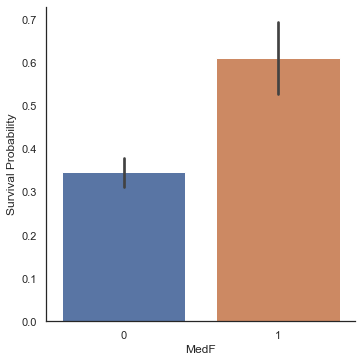

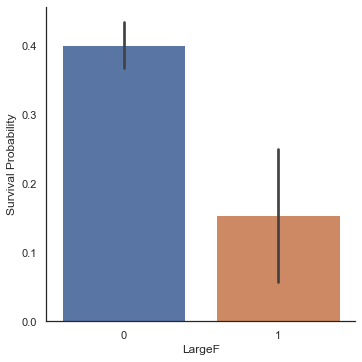

In [103]:
g = sns.factorplot(x='Single',y='Survived',data=dataset,kind='bar')
g = g.set_ylabels('Survvial Probability')

g = sns.factorplot(x="SmallF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x="MedF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

g = sns.factorplot(x="LargeF",y="Survived",data=dataset,kind="bar")
g = g.set_ylabels("Survival Probability")

가족규모에 따른 factorplot에서 소규모나 중간규모의 가족이 혼자나 대가족보다 생존률이 높은 것을 알 수 있다.

In [179]:
# Title, Embarked 변수 one-hot encoding
dataset = pd.get_dummies(dataset, columns=['Title'])
dataset = pd.get_dummies(dataset, columns=['Embarked'],prefix='Em')
### prefix : 원핫인코딩된 새로운 변수의 앞글자(접두사)

In [180]:
dataset.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,...,SmallF,MedF,LargeF,Title_0,Title_1,Title_2,Title_3,Em_C,Em_Q,Em_S
0,1,0.0,3,0,22.0,1,0,A/5 21171,1.981001,NaN,...,1,0,0,0,0,1,0,0,0,1
1,2,1.0,1,1,38.0,1,0,PC 17599,4.266662,C85,...,1,0,0,0,1,0,0,1,0,0
2,3,1.0,3,1,26.0,0,0,STON/O2. 3101282,2.070022,NaN,...,0,0,0,0,1,0,0,0,0,1
3,4,1.0,1,1,35.0,1,0,113803,3.972177,C123,...,1,0,0,0,1,0,0,0,0,1
4,5,0.0,3,0,35.0,0,0,373450,2.085672,NaN,...,0,0,0,0,0,1,0,0,0,1


## 5.3. Cabin

In [107]:
dataset['Cabin'].head()

0     NaN
1     C85
2     NaN
3    C123
4     NaN
Name: Cabin, dtype: object

In [108]:
dataset['Cabin'].describe()

count                 292
unique                186
top       B57 B59 B63 B66
freq                    5
Name: Cabin, dtype: object

In [109]:
dataset['Cabin'].isnull().sum()

1007

Cabin 변수는 292개 값과 1007개의 결측치가 있다. 객실이 없는 승객은 객실 번호 대신 결측값을 가진 것이라고 추측할 수 있다.

In [110]:
dataset['Cabin'][dataset['Cabin'].notnull()].head()

1      C85
3     C123
6      E46
10      G6
11    C103
Name: Cabin, dtype: object

In [181]:
# 결측값 X로 대체, 나머지는 첫글자만 남김
dataset['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'X' for i in dataset['Cabin']])

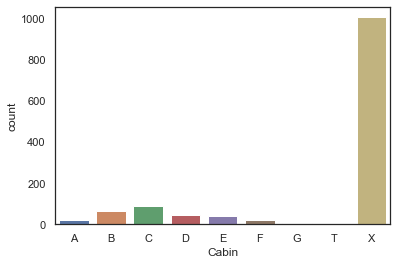

In [112]:
g = sns.countplot(dataset['Cabin'],order=['A','B','C','D','E','F','G','T','X'])

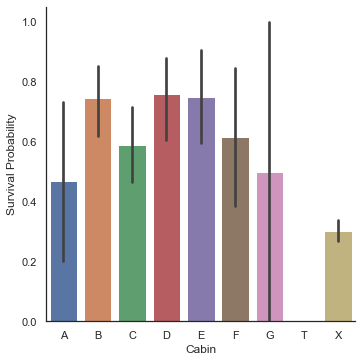

In [113]:
g = sns.factorplot(y='Survived',x='Cabin',data=dataset,kind='bar',order=['A','B','C','D','E','F','G','T','X'])
g = g.set_ylabels('Survival Probability')

In [182]:
dataset = pd.get_dummies(dataset,columns=['Cabin'],prefix='Cabin')

객실이 있는 승객 수가 적어 생존률을 구별할 수 없다. 하지만 일반적으로 객실이 있는 승객이 없는 승객(X)보다 생존률이 높다는 것을 알 수 있다. 특히 B,C,D,E,F가 그렇다.

## 5.4. Ticket

In [114]:
dataset['Ticket'].head()

0           A/5 21171
1            PC 17599
2    STON/O2. 3101282
3              113803
4              373450
Name: Ticket, dtype: object

접두사가 같은 티켓이 같은 객실에 예약될 수 있다. 동일한 접두사를 가진 티켓은 유사한 Pclass와 생존률을 가질지도 모른다. 따라서 Ticket 변수를 접두사로 대체한다.

In [183]:
# 접두사를 추출해 Ticket 변수 처리. 접두사가 없으면 X 반환
Ticket = []
for i in list(dataset.Ticket):
    if not i.isdigit():
        Ticket.append(i.replace('.','').replace('/','').strip().split(' ')[0])  #접두사 추출
    else:
        Ticket.append('X')
            
dataset['Ticket'] = Ticket
dataset['Ticket'].head()

0        A5
1        PC
2    STONO2
3         X
4         X
Name: Ticket, dtype: object

In [184]:
dataset = pd.get_dummies(dataset, columns=['Ticket'],prefix='T')

In [185]:
# Pclass 변수 one-hot encoding
dataset['Pclass'] = dataset['Pclass'].astype('category')
dataset = pd.get_dummies(dataset, columns=['Pclass'],prefix='Pc')

In [186]:
# 불필요한 변수 제거
dataset.drop(labels=['PassengerId'],axis=1,inplace=True)

In [187]:
dataset.head()

,Survived,Sex,Age,SibSp,Parch,Fare,Fsize,Single,SmallF,MedF,...,T_STONO,T_STONO2,T_STONOQ,T_SWPP,T_WC,T_WEP,T_X,Pc_1,Pc_2,Pc_3
0,0.0,0,22.0,1,0,1.981001,2,0,1,0,...,0,0,0,0,0,0,0,0,0,1
1,1.0,1,38.0,1,0,4.266662,2,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,1.0,1,26.0,0,0,2.070022,1,1,0,0,...,0,1,0,0,0,0,0,0,0,1
3,1.0,1,35.0,1,0,3.972177,2,0,1,0,...,0,0,0,0,0,0,1,1,0,0
4,0.0,0,35.0,0,0,2.085672,1,1,0,0,...,0,0,0,0,0,0,1,0,0,1


# 6. Modeling

In [188]:
# train, test dataset 분리
train = dataset[:train_len]
test = dataset[train_len:]
test.drop(labels=['Survived'],axis=1,inplace=True)

In [189]:
# train 의 변수와 target 분리
train['Survived'] = train['Survived'].astype(int)
Y_train = train['Survived']
X_train = train.drop(labels=['Survived'],axis=1)

## 6.1. Simple modeling

10개의 인기있는 분류기를 비교해 kfold 교차검증으로 각 정확도의 평균을 평가한다.
- SVC / Decision Tree / AdaBoost / Random Forest / Extra Trees / Gradient Boosting / Multiple layer perceptron(neural network) / KNN / Logistic regression / Linear Discriminant Analysis

In [190]:
# Kfold 교차검증 모델
kfold = StratifiedKFold(n_splits=10)

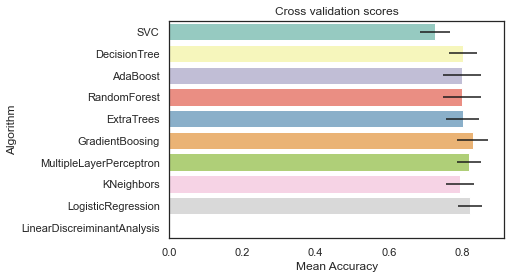

In [191]:
# 10개 알고리즘 모델링

warnings.filterwarnings('ignore')


random_state = 2
classifiers = []

classifiers.append(SVC(random_state=random_state))
classifiers.append(DecisionTreeClassifier(random_state=random_state))
classifiers.append(AdaBoostClassifier(DecisionTreeClassifier(random_state=random_state),random_state=random_state,learning_rate=0.1))
classifiers.append(RandomForestClassifier(random_state=random_state))
classifiers.append(ExtraTreesClassifier(random_state=random_state))
classifiers.append(GradientBoostingClassifier(random_state=random_state))
classifiers.append(MLPClassifier(random_state=random_state))
classifiers.append(KNeighborsClassifier())
classifiers.append(LogisticRegression(random_state = random_state))
classifiers.append(LinearDiscriminantAnalysis())

cv_results = []
for classifier in classifiers :
    cv_results.append(cross_val_score(classifier, X_train, y = Y_train, scoring = 'accuracy', cv = kfold))
    
cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())
    
cv_res = pd.DataFrame({'CrossValMeans':cv_means,'CrossValerrors':cv_std,
                      'Algorithm':['SVC','DecisionTree','AdaBoost','RandomForest','ExtraTrees',
                                  'GradientBoosing','MultipleLayerPerceptron','KNeighbors',
                                  'LogisticRegression','LinearDiscreiminantAnalysis']})

g = sns.barplot('CrossValMeans','Algorithm',data=cv_res,palette='Set3',orient='h',**{'xerr':cv_std})
g.set_xlabel('Mean Accuracy')
g = g.set_title('Cross validation scores')

앙상블 모델링을 위해 SVC, AdaBoost, RandomForest, ExtraTrees, GradientBoosting 분류기를 선택한다.

### 6.1.2. Hyperparameter tunning for best models

AdaBoost, ExtraTree, RandomForest, GradientBoosting, SVC 분류기에 대해 최적화했다. 원본에는 cpu가 4개여서 n_jobs=4로 설정되어있지만 UnicodeEncodeError로 삭제했다. 하지만 n_jobs를 설정하면 시간이 오래걸린다.

#### Adaboost

In [192]:
DTC = DecisionTreeClassifier()
adaDTC = AdaBoostClassifier(DTC, random_state=7)
ada_param_grid = {"base_estimator__criterion" : ["gini", "entropy"],
              "base_estimator__splitter" :   ["best", "random"],
              "algorithm" : ["SAMME","SAMME.R"],
              "n_estimators" :[1,2],
              "learning_rate":  [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3,1.5]}

gsadaDTC = GridSearchCV(adaDTC,param_grid=ada_param_grid,cv=kfold,scoring='accuracy',verbose=1)
gsadaDTC.fit(X_train,Y_train)
ada_best = gsadaDTC.best_estimator_

Fitting 10 folds for each of 112 candidates, totalling 1120 fits


In [193]:
gsadaDTC.best_score_

0.8241317671092953

#### Extra Trees

In [195]:
ExtC = ExtraTreesClassifier()
ex_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsExtC = GridSearchCV(ExtC,param_grid=ex_param_grid,cv=kfold,scoring='accuracy',verbose=1)
gsExtC.fit(X_train,Y_train)
ExtC_best = gsExtC.best_estimator_

gsExtC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8308605720122575

#### RandomForestClassifier

In [196]:
RFC = RandomForestClassifier()
rf_param_grid = {"max_depth": [None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [False],
              "n_estimators" :[100,300],
              "criterion": ["gini"]}

gsRFC = GridSearchCV(RFC,param_grid=rf_param_grid,cv=kfold,scoring='accuracy',verbose=1)
gsRFC.fit(X_train,Y_train)
RFC_best = gsRFC.best_estimator_

gsRFC.best_score_

Fitting 10 folds for each of 54 candidates, totalling 540 fits


0.8331716036772215

#### Gradient boosting

In [197]:
GBC = GradientBoostingClassifier()
gb_param_grid = {'loss' : ["deviance"],
              'n_estimators' : [100,200,300],
              'learning_rate': [0.1, 0.05, 0.01],
              'max_depth': [4, 8],
              'min_samples_leaf': [100,150],
              'max_features': [0.3, 0.1] 
              }

gsGBC = GridSearchCV(GBC,param_grid = gb_param_grid, cv=kfold, scoring='accuracy', verbose = 1)
gsGBC.fit(X_train,Y_train)
GBC_best = gsGBC.best_estimator_

gsGBC.best_score_

Fitting 10 folds for each of 72 candidates, totalling 720 fits


0.8342696629213483

#### SVC

In [198]:
SVMC = SVC(probability=True)
svc_param_grid = {'kernel': ['rbf'], 
                  'gamma': [ 0.001, 0.01, 0.1, 1],
                  'C': [1, 10, 50, 100,200,300, 1000]}

gsSVMC = GridSearchCV(SVMC,param_grid = svc_param_grid, cv=kfold, scoring="accuracy", verbose = 1)
gsSVMC.fit(X_train,Y_train)
SVMC_best = gsSVMC.best_estimator_

gsSVMC.best_score_

Fitting 10 folds for each of 28 candidates, totalling 280 fits


0.8331332992849847

### 6.1.3. Plot learning curves

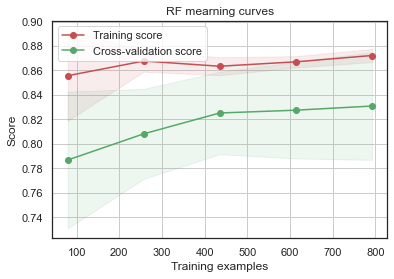

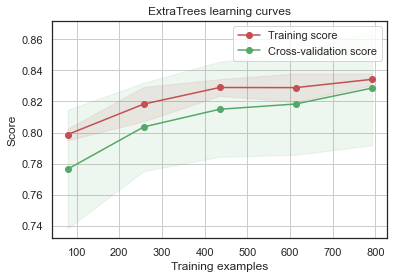

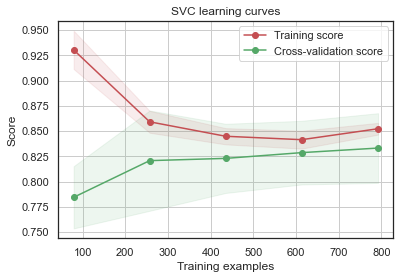

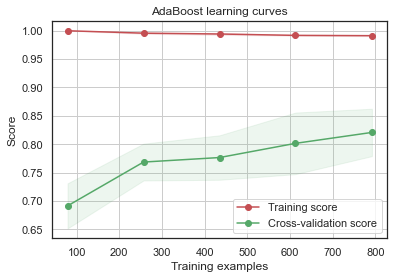

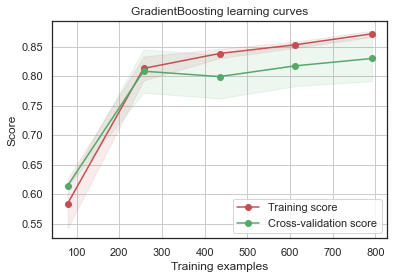

In [199]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1,1.0,5)):
    # test와 trainig의 학습곡선에 대한 간단한 그래프
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    train_sizes,train_scores,test_scores = learning_curve(
    estimator,X,y,cv=cv,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes,train_scores_mean - train_scores_std,
                    train_scores_mean+train_scores_std, alpha=0.1,color='r')
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color='g')
    plt.plot(train_sizes,train_scores_mean,'o-',color="r", label='Training score')
    plt.plot(train_sizes,test_scores_mean,'o-',color="g", label='Cross-validation score')
    plt.legend(loc='best')
    return plt

g = plot_learning_curve(gsRFC.best_estimator_,'RF mearning curves',X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsExtC.best_estimator_,'ExtraTrees learning curves',X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsSVMC.best_estimator_,'SVC learning curves',X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsadaDTC.best_estimator_,'AdaBoost learning curves',X_train,Y_train,cv=kfold)
g = plot_learning_curve(gsGBC.best_estimator_,'GradientBoosting learning curves',X_train,Y_train,cv=kfold)

GradientBoosting과 Adaboost 분류기는 trainig set에 과적합하는 경향이 있다. 하지만 Cross validation score의 그래프가 증가하는 것으로 보아 training 데이터를 더 많이 학습시키면 성능이 더 좋아질 수도 있다. <br>
SCV와 ExtraTree 분류기는 training 곡선과 cross validations 곡선이 밀접하므로 예측을 잘 일반화시킨다고 볼 수 있다.

### 6.1.4. Feature importance of tree based classifiers

생존률 예측에 가장 중요한 변수를 보기 위해 4개의 트리 기반 분류기에 변수 중요도를 확인해보자.

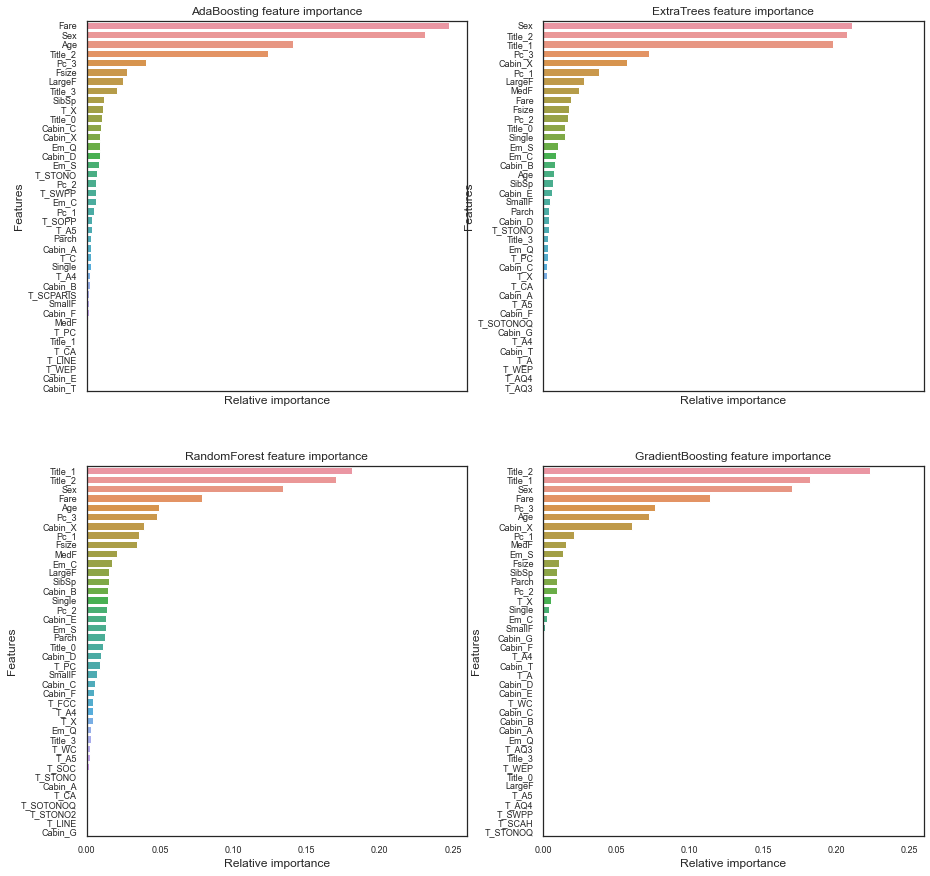

In [200]:
nrows = ncols = 2
fig,axes = plt.subplots(nrows=nrows,ncols=ncols,sharex='all',figsize=(15,15))

names_classifiers = [('AdaBoosting',ada_best),('ExtraTrees',ExtC_best),('RandomForest',RFC_best),('GradientBoosting',GBC_best)]

nclassifier = 0
for row in range(nrows):
    for col in range(ncols):
        name = names_classifiers[nclassifier][0]
        classifier = names_classifiers[nclassifier][1]
        indices = np.argsort(classifier.feature_importances_)[::-1][:40]
        g = sns.barplot(y=X_train.columns[indices][:40],
                       x=classifier.feature_importances_[indices][:40],
                       orient='h',ax=axes[row][col])
        g.set_xlabel('Relative importance',fontsize=12)
        g.set_ylabel('Features',fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title(name+' feature importance')
        nclassifier += 1

4개의 트리 기반 분류기 Adaboost, ExtraTree, RandomForest, GradientBoosting에 대한 변수 중요도를 알아봤다. 상대적 중요도에 따라 상위 변수가 달라진다. 이는 그 예측들이 같은 변수에 기반하지 않는다는 것을 의미한다. 하지만 Fare, Title_2, Age, Sex와 같은 중요한 변수는 공통된다. Title_2는 Ms/Mlle/Mme/Miss/Ms 를 나타내고 Sex와 상관관계가 높다.
- Pc_1, Pc_2, Pc_3, Fare : 사회적 지위
- Sex, Title_2, Title_3 : 성별
- Age, Title_1 : 나이
- Fsize, LargeF, MedF, Single : 가족 규모

4개의 분류기에서 본 변수 중요도에 따르면, 생존률은 배 안에서 승객의 위치보다 승객들의 연령, 성별, 가족 규모, 사회직 지위 등과 더 관련이 있다.

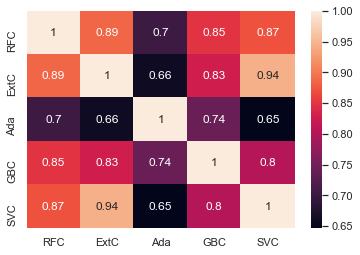

In [201]:
test_Survived_RFC = pd.Series(RFC_best.predict(test), name="RFC")
test_Survived_ExtC = pd.Series(ExtC_best.predict(test), name="ExtC")
test_Survived_SVMC = pd.Series(SVMC_best.predict(test), name="SVC")
test_Survived_AdaC = pd.Series(ada_best.predict(test), name="Ada")
test_Survived_GBC = pd.Series(GBC_best.predict(test), name="GBC")

# 모든 분류기의 결과 연결
ensemble_results = pd.concat([test_Survived_RFC,test_Survived_ExtC,test_Survived_AdaC,test_Survived_GBC, test_Survived_SVMC],axis=1)

g= sns.heatmap(ensemble_results.corr(),annot=True)

AdaBoost와 다른 분류기의 비교를 제외하고는, 5개의 분류기가 예측을 꽤 비슷하게 한 것으로 보인다. 하지만 약간의 차이가 있으므로 ensembling vote를 충분히 고려할만하다.

## 6.2. Ensemble modeling

### 6.2.1. Combining models

In [203]:
votingC = VotingClassifier(estimators=[('rfc',RFC_best),('extc',ExtC_best),
                                      ('svc',SVMC_best),('adac',ada_best),
                                      ('gbc',GBC_best)],voting='soft')
votingC = votingC.fit(X_train,Y_train)

## 6.3. Prediction

### 6.3.1. Predict and Submit results

In [204]:
test_Survived = pd.Series(votingC.predict(test),name='Survived')
results = pd.concat([IDtest,test_Survived],axis=1)
results.to_csv('ensemble_python_voting.csv',index=False)